In [1]:
!pip install -qU datasets fsspec transformers evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 108.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia

In [ ]:
import wandb
import os 
# Insert your WANDB key
wandb.login(key='')
os.environ["WANDB_PROJECT"] = "NLP"
os.environ["WANDB_LOG_MODEL"] = "end"

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: buinguyenkhai24 (buinguyenkhai24-hust) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer, pipeline
from evaluate import evaluator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2025-06-07 02:43:34.388974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749264214.567627      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749264214.622787      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# CHANGE MODEL_NAME, LORA_R and LORA_ALPHA
MODEL_NAME = "google/electra-base-discriminator"
# "google/electra-base-discriminator", "FacebookAI/roberta-base", "SpanBERT/spanbert-base-cased"
LORA_R = 4
LORA_ALPHA = 4
EPOCHS = 5
LORA_TARGETS = ["query", "key", "value", "attention.output.dense"]

In [5]:
trainval_squad = load_dataset("squad", split="train")
test_squad = load_dataset("squad", split="validation")

README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [6]:
trainval_squad = trainval_squad.train_test_split(test_size=0.2)

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map (num_proc=4):   0%|          | 0/70079 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/17520 [00:00<?, ? examples/s]

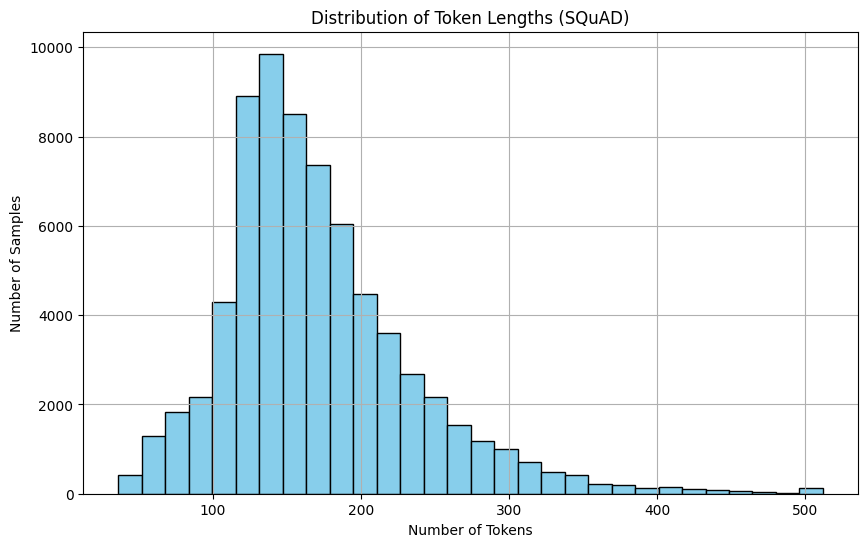

In [8]:
def get_token_length(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=512,
        truncation="only_second",
        return_offsets_mapping=True,
        padding=False,
        return_length=True,
    )

    return inputs

token_length = trainval_squad.map(get_token_length, batched=True, remove_columns=trainval_squad['train'].column_names, num_proc=4)
lengths = token_length['train']['length']

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Token Lengths (SQuAD)")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

In [9]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=512,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [10]:
tokenized_squad = trainval_squad.map(preprocess_function, batched=True, remove_columns=trainval_squad["train"].column_names, num_proc=4)

Map (num_proc=4):   0%|          | 0/70079 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/17520 [00:00<?, ? examples/s]

In [11]:
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
data_collator = DataCollatorWithPadding(tokenizer)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForQuestionAnswering were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
print(model)

ElectraForQuestionAnswering(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

In [ ]:
from peft import LoraConfig, get_peft_model, PeftModel

config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGETS,
    lora_dropout=0.1,
    bias="none",
    task_type="QUESTION_ANS"
)
model = get_peft_model(model, config)

model.print_trainable_parameters()

In [ ]:
training_args = TrainingArguments(
    dataloader_num_workers = 4,
    output_dir="best_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=500,
    learning_rate=2e-5,
    lr_scheduler_type='cosine_with_min_lr',
    lr_scheduler_kwargs={'min_lr_rate':0.1},
    warmup_ratio=0.1,
    fp16=True,
    max_grad_norm = 1.0,
    optim="adamw_torch",
    gradient_accumulation_steps=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to="wandb",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
#    compute_metrics=compute_metrics
)

trainer.train()

In [ ]:
trainer.save_model("./best_model")
tokenizer.save_pretrained("./best_model")

In [ ]:
print(model)

In [ ]:
from datasets import load_dataset
from evaluate import evaluator
from transformers import AutoModelForSequenceClassification, pipeline

task_evaluator = evaluator("question-answering")
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

eval_results = task_evaluator.compute(
    model_or_pipeline=qa_pipeline,
    data=trainval_squad["test"], # CHANGE TO test_squad if doing testing
    tokenizer=tokenizer,
    metric="squad",
    strategy="simple",
)

print(eval_results)

In [ ]:
question = "How many programming languages does BLOOM support?"
context = "BLOOM has 176 billion parameters and can generate text in 46 languages natural languages and 13 programming languages."

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("best_model")
inputs = tokenizer(question, context, return_tensors="pt")

In [ ]:
import torch
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
model = PeftModel.from_pretrained(model, "best_model")
model.eval()

with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
answer_start_index = outputs.start_logits.argmax()
answer_end_index = outputs.end_logits.argmax()

In [ ]:
predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer.decode(predict_answer_tokens)

In [ ]:
wandb.finish()